# HW03 Finetuning

I recommend to work in [Lightning studio](https://lightning.ai/simecek/studios/fastai-transfer-learning-fine-tuning~01hv3p406bs3pebc3xm2qwtwz1) (and not Colab), because of preinstalled environment and permanent disk space.

## Data preparation

 1. You need to upload your dataset to the virtual machine. Because the data are still relatively small, the easiest way is to just ZIP you data and use "Upload Files" button in the top loft corner.
 2. Unzip your data either from the Terminal or directly in jupyter notebook `!unzip YOURFILENAME.zip`
 3. *[OPTIONAL]* Arrange image files into the schema below

```
DATASET_NAME/
│
├── train/
│   ├── CATEGORY1/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
│   ├── CATEGORY2/
│   │   ├── image1.jpg
│   │   ├── image2.jpg
│   │   └── ...
│   └── ...
│
└── test/
    ├── CATEGORY1/
    │   ├── image1.jpg
    │   ├── image2.jpg
    │   └── ...
    ├── CATEGORY2/
    │   ├── image1.jpg
    │   ├── image2.jpg
    │   └── ...
    └── ...
```

If the data are in this form, you can obtain dataloaders as below. Otherwise, adapt `DataBlocks` accordingly.


In [4]:
!git lfs install

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


In [5]:
!git clone https://huggingface.co/datasets/vojtam/vegetables

Cloning into 'vegetables'...
Filtering content: 100% (691/691), 305.98 MiB | 134.59 MiB/s, done.



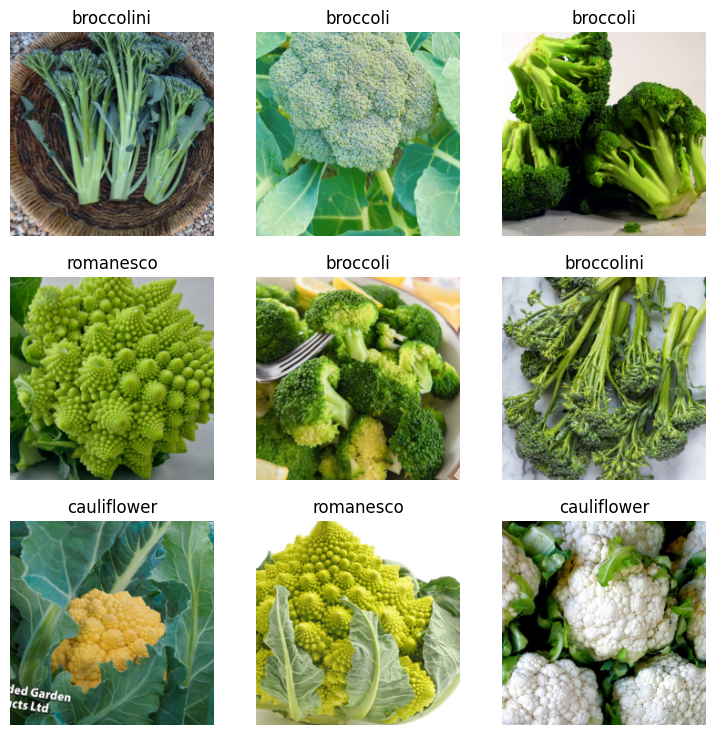

In [17]:
from fastai.vision.all import *
from pathlib import Path


path = Path('vegetables') / 'train'

dls = ImageDataLoaders.from_folder(
    path,                 # Path to the train folder
    train='.',            # Use the entire train folder for splitting
    valid_pct=0.2,        # 20% of the data will be used for validation
    seed=42,              # Set a seed for reproducibility
    item_tfms=Resize(460),# Resize the images to 460x460 (or your desired size)
    batch_tfms=aug_transforms(size=224, min_scale=0.75), # Data augmentation 
    bs=64                 # Batch size 64
)

dls.show_batch(max_n=9)

In [18]:
import warnings

# to ignore the palette warnings
warnings.filterwarnings(
    "ignore",
    message="Palette images with Transparency expressed in bytes should be converted to RGBA images",
    category=UserWarning
)

## Train the model

  1. Choose a pretrained model
  2. Find optimal learning rate
  3. Fine-tune the model

Regarding the model, use rather [something smaller](https://www.kaggle.com/code/jhoward/which-image-models-are-best) from `timm` package. Architectures like convexnet, resnet, vgg or mobilenet should be fine.

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [20]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

SuggestedLRs(valley=0.0008317637839354575)

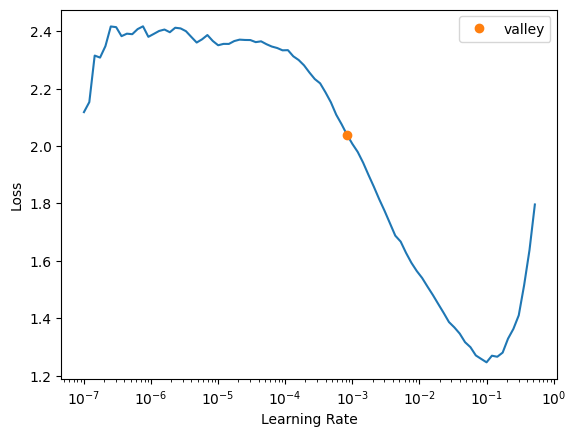

In [21]:
learn.lr_find()

In [22]:
lr = 0.0008317637839354575 # set optimal learning rate here
epochs = 10 # set number of one-cycles for training, try to experiment a bit

In [23]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(epochs, lr)

epoch,train_loss,valid_loss,error_rate,time
0,2.112032,1.620886,0.571429,00:08


epoch,train_loss,valid_loss,error_rate,time
0,1.268578,0.906114,0.285714,00:07
1,1.114757,0.637125,0.193277,00:07
2,0.945413,0.501036,0.176471,00:08
3,0.818959,0.439213,0.151261,00:07
4,0.735362,0.408320,0.117647,00:07
5,0.661738,0.398903,0.126050,00:07
6,0.587884,0.398914,0.126050,00:07
7,0.516575,0.395460,0.117647,00:07
8,0.479036,0.392448,0.117647,00:08
9,0.447603,0.389991,0.117647,00:07


Check how the model is doing...

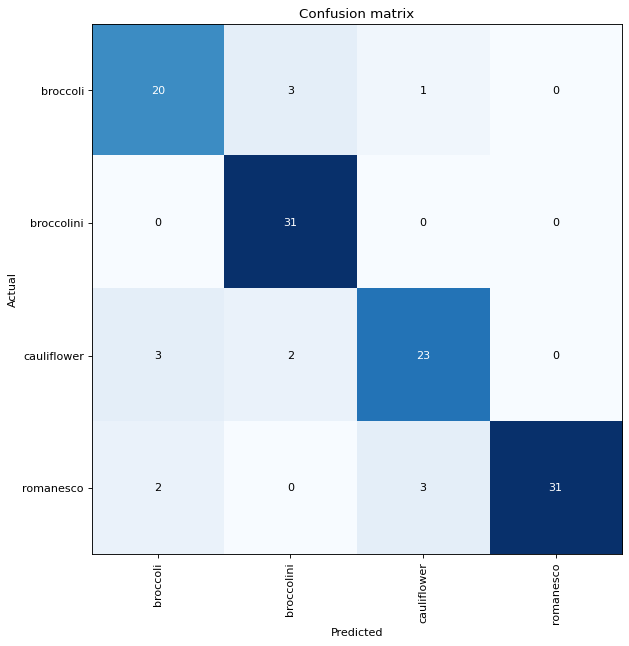

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

...and see the misclassified images in the validation set.

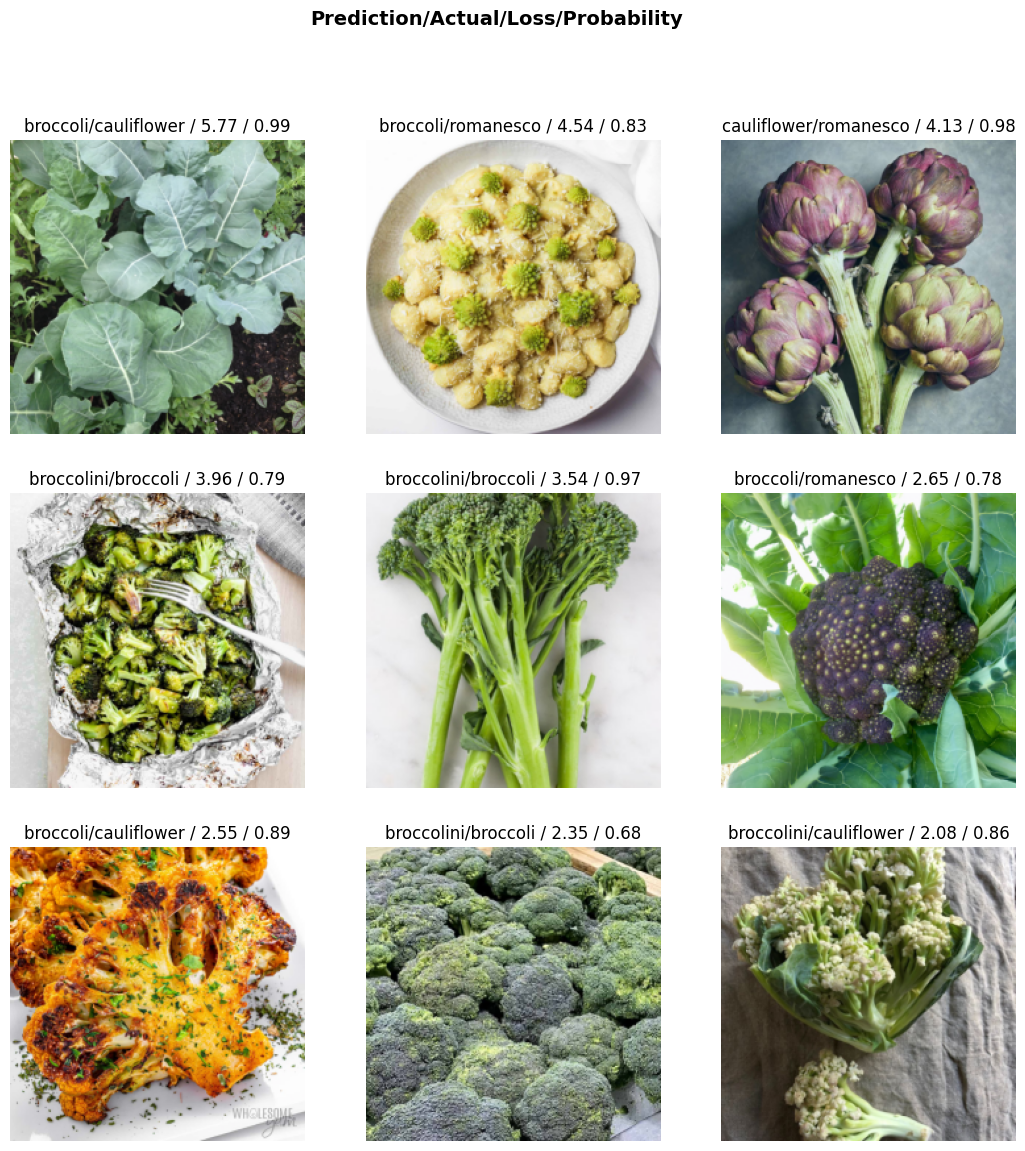

In [25]:
interp.plot_top_losses(9, figsize=(13,13))

If you see a mess, you might want to clean your data - there is a widget for that. It will list the most suspicios images (=highest loss) per set (train/valid) and category. Mark them for the deletion...

In [15]:
from fastai.vision.widgets import *

# TODO
cleaner = ImageClassifierCleaner(learn)
cleaner

...and now actually delete them. Note you now need ro return to rerun this notebook from the first cell (your dataloaders poiting to files that have been deleted). But you have a good chance your model will better now.

In [16]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
print(len(cleaner.delete()))

0


## Test the model on a test set

In [26]:
# Create a test DataLoader
test_path = Path('vegetables') / 'test'
test_dl = learn.dls.test_dl(get_image_files(test_path))

In [27]:
# Get predictions
preds, targets = learn.get_preds(dl=test_dl)
pred_labels = torch.argmax(preds, dim=1)

In [28]:
# Get class names
class_names = learn.dls.vocab
# Convert predictions to class names
pred_class_names = [class_names[i] for i in pred_labels]
true_class_names = [Path(t).parent.name for t in test_dl.items]

In [29]:
from statistics import mean

print("Test error rate:")
print(1 - mean([actual == predicted for actual, predicted in zip(true_class_names, pred_class_names)]))
   

Test error rate:
0.11578947368421055


## Let us save the model

In [35]:
learn.export('/teamspace/studios/this_studio/vegetables_finetuned.pkl')

Do not forget to **download** `model.pkl` to your laptop. You will need it later.